In [1]:
import torch 
import numpy as np
import pandas as pd 
from utilities import *
from math import ceil
import matplotlib.pyplot as plt

#from LSTM import Dataset, dataloader, LSTM_reg, plot_loss

### Load dataset and normalize with MinMax

In [2]:
big_df = pd.read_csv('Datasets/sp500_sentiment_non_weighted.csv')
big_df['Close'] = (big_df['Close']-big_df['Close'].min())/(big_df['Close'].max()-big_df['Close'].min())
big_df

,Unnamed: 0,date,Volume,Close,Positive,Negative,Neutral,Price_change
0,0,2010-01-05,1.111477e+07,0.048207,0.157785,0.489590,0.352625,1
1,1,2010-01-06,9.592200e+06,0.048469,0.159253,0.114102,0.726645,1
2,2,2010-01-07,1.264640e+07,0.050394,0.441000,0.012006,0.546994,1
3,3,2010-01-08,1.508503e+07,0.051786,0.039152,0.384472,0.576376,1
4,4,2010-01-11,7.396000e+06,0.052632,0.114053,0.029774,0.856173,1
...,...,...,...,...,...,...,...,...
2603,2603,2020-06-05,2.503270e+07,0.918674,0.567891,0.070503,0.361606,1
2604,2604,2020-06-08,2.303770e+07,0.934946,0.523481,0.124646,0.351873,1
2605,2605,2020-06-09,2.969893e+07,0.924280,0.296441,0.337487,0.366072,-1
2606,2606,2020-06-10,3.795272e+07,0.917070,0.390972,0.240399,0.368628,-1


### Process dataset to a supervised time-series format
Create a time series dataset, features consist of the previous #seq_len day's close price while today's close price is the label.

In [3]:
seq_len = 1
# start creating sequences only after the first seq_len elements have passed 
X = np.zeros((big_df.shape[0] - seq_len, seq_len , 4), dtype=float) #3d array
y = np.zeros((big_df.shape[0] - seq_len, seq_len), dtype=float)
print("X shape :",X.shape)
print("y shape :",y.shape)

X shape : (2607, 1, 4)
y shape : (2607, 1)


In [4]:
for i in range(seq_len , X.shape[0] + seq_len) :
    for j in range(seq_len) :
        prev_elems = big_df.iloc[i-(seq_len-j)][['Close', 'Positive', 'Negative', 'Neutral']] # previous available date
        # only the desired values
        prev_elems = [ prev_elems[p] for p in range(len(prev_elems))]
        prev_elems = np.array(prev_elems)
        # Store previous day close price as feature 
        X[i-seq_len, j] = prev_elems
        # Store "today's" close price as label
        y[i-seq_len] = big_df.iloc[i]['Close']

In [5]:
X.shape

(2607, 1, 4)

In [6]:
y.shape

(2607, 1)

In [7]:
import torch
import numpy as np
from utilities import *
from math import ceil
import matplotlib.pyplot as plt
from tqdm import tqdm

import torch.nn as nn
from torch.utils.data import Dataset
from torch.utils.data import DataLoader


class Dataset(Dataset):
    def __init__(self, X, y, trans=None):
        X = torch.Tensor(X)
        y = torch.Tensor(y)
        self.data = list(zip(X, y))   # features zipped with label
        self.trans = trans

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        if self.trans is not None:     # If transform has been declared apply it .
            return self.trans(self.data[idx])
        else:
            return self.data[idx]


def dataloader(dataset, batch=1):
    dloader = DataLoader(dataset, batch_size=batch)
    return dloader


class LSTM_reg(nn.Module):
    ''' LSTM class for regression purposes.'''
    def __init__(self, num_classes, input_size, hidden_size, lstm_layers, dropout=0.3, fc_size=124) :
        super(LSTM_reg, self).__init__()
        self.num_classes = num_classes # number of classes
        self.input_size = input_size   # features input number
        self.lstm_layers = lstm_layers # number of lstm stacked layers
        self.hidden_size = hidden_size # hidden states

        # Network's layers
        self.lstm = nn.LSTM(input_size=self.input_size, hidden_size=self.hidden_size,
                            num_layers=self.lstm_layers, batch_first=True, dropout=dropout) 
        
        self.fc1 = nn.Linear(hidden_size * lstm_layers, fc_size)
        self.fc2 = nn.Linear(fc_size, self.num_classes)
        self.relu = nn.ReLU()

    def forward(self, x, hidden=None, return_hidden=False) :

        lstm_output, hidden = self.lstm(x, hidden)
        output = self.relu(lstm_output)
        output = self.fc1(output)
        output = self.relu(output)
        output = self.fc2(output)

        # if in eval mode only return network's prediction, except if specified otherwise by user.
        if ((not self.training ) and return_hidden):
            return output
        else :
            return output, hidden


    def train_model(self, train_loader, epochs=200, val_loader=None, print_freq=100, lr=0.0003,
                    optimizer=None, criterion=None) :
        
        if optimizer==None : optimizer = torch.optim.Adam(self.parameters(), lr=lr)
        if criterion==None : criterion = torch.nn.MSELoss()

        plot_loss_tr = []
        plot_loss_val = []
        for epoch in tqdm(range(epochs)):
            avg_train_loss = 0 
            self.train() # train mode for model
            hidden_tr = None # initial hidden state
            
           # h_0 = torch.zeros(30, h_0.shape[1], self.hidden_size) 
           # c_0 = torch.zeros(30, h_0.shape[1], self.hidden_size)
            for i, batch in enumerate(train_loader):
                X_batch, y_batch = batch
                # in case of incomplete batch pass hidden states as zero to avoid dimension problems
             #   if h_0.shape[0] != X_batch.shape[0] :
              #      h_0 = torch.zeros(X_batch.shape[0], h_0.shape[1], self.hidden_size)
               #     c_0 = torch.zeros(X_batch.shape[0], h_0.shape[1], self.hidden_size)
                outputs, hidden_tr = self.forward(X_batch ) #, hidden_tr) #forward pass
               # print(y_batch.shape)
               # print(outputs.shape)
               # print("out 0 ",outputs[-1])
                h_0, c_0 = hidden_tr
                h_0.detach_(), c_0.detach_()  # "turn-off" gradients
                hidden_tr = (h_0, c_0)

                optimizer.zero_grad()  # calculate the gradient
                loss = criterion(outputs, y_batch)  # obtain the loss function
                loss.backward() # calculates gradients of inputs
                avg_train_loss += loss.item()
            avg_train_loss = avg_train_loss/(i+1)
            plot_loss_tr.append(avg_train_loss) # mean training loss over an epoch
            
            ## Compute validation loss
            avg_val_loss = 0
            self.eval()
            hidden_val = None  # initial hidden
            for j, batch_v in enumerate(val_loader):
                X_val, y_val = batch_v
                val_outs, hidden_val = self.forward(X_val, hidden_val) #forward pass
                val_loss = criterion(val_outs, y_val)
                avg_val_loss += val_loss.item()
            avg_val_loss = avg_val_loss/(j+1)
            plot_loss_val.append(avg_val_loss) # mean validation loss over an epoch

            optimizer.step() #improve from loss, i.e backprop
            if epoch % print_freq == 0:
                print("Epoch: %d, train_loss: %1.5f,  val_loss: %1.5f " % (epoch, avg_train_loss, avg_val_loss))
        
        # Training loss history returned
        return plot_loss_tr, plot_loss_val


### Data splitting into train,val, test . 

In [8]:
# fraction of the test set.
percentage = 0.3
split_tr = ceil(X.shape[0] * (1-percentage))
split_val = ceil(X.shape[0] * (1- percentage/2))

X_train = X[0:split_tr]
y_train = y[0:split_tr]
X_val= X[split_tr: split_val]
y_val= y[split_tr: split_val]
X_test= X[split_val:]
y_test= y[split_val:]
print(f"Train data shapes X:{X_train.shape} , y:{y_train.shape}")
print(f"Test data shapes X:{X_test.shape} , y:{y_test.shape}")
print(f"Val data shapes X:{X_val.shape} , y:{y_val.shape}")

Train data shapes X:(1825, 1, 4) , y:(1825, 1)
Test data shapes X:(391, 1, 4) , y:(391, 1)
Val data shapes X:(391, 1, 4) , y:(391, 1)


In [9]:
tr_dataset = Dataset(X_train, y_train)
tr_loader = dataloader(tr_dataset, batch=5)

val_dataset = Dataset(X_val, y_val)
val_loader = dataloader(val_dataset)

test_dataset = Dataset(X_test, y_test)
test_loader = dataloader(test_dataset)

In [10]:
#hyperparameters
num_epochs = 300 #1000 epochs
learning_rate = 0.0001 #0.001 lr

input_size = 4 #number of features
hidden_size = 50 #number of features in hidden state
num_layers = 1 #number of stacked lstm layers

num_classes = 1 #number of output classes
criterion = nn.MSELoss()

lstm_reg = LSTM_reg(num_classes, input_size, hidden_size, lstm_layers=num_layers, dropout=0.3, fc_size=128) #our lstm class

C:\Users\Konpoul\miniconda3\envs\torch\lib\site-packages\torch\nn\modules\rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


In [11]:
train_loss, val_loss = lstm_reg.train_model(tr_loader, epochs=num_epochs, val_loader=val_loader)

  0%|                                                                                          | 0/300 [00:00<?, ?it/s]C:\Users\Konpoul\miniconda3\envs\torch\lib\site-packages\torch\nn\modules\loss.py:520: UserWarning: Using a target size (torch.Size([5, 1])) that is different to the input size (torch.Size([5, 1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
C:\Users\Konpoul\miniconda3\envs\torch\lib\site-packages\torch\nn\modules\loss.py:520: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([1, 1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
  0%|▎                                                                                 | 1/300 [00:00<02:38,  1.89it/s]

Epoch: 0, train_loss: 0.05713,  val_loss: 0.34784 


 34%|██████████████████████████▉                                                     | 101/300 [00:51<01:39,  2.00it/s]

Epoch: 100, train_loss: 0.05639,  val_loss: 0.01480 


 67%|█████████████████████████████████████████████████████▌                          | 201/300 [01:42<00:49,  1.98it/s]

Epoch: 200, train_loss: 0.10294,  val_loss: 0.00753 


100%|████████████████████████████████████████████████████████████████████████████████| 300/300 [02:31<00:00,  1.98it/s]


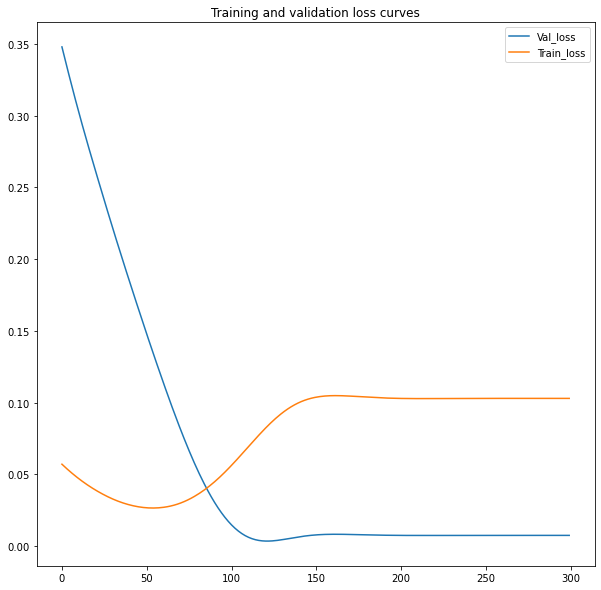

In [13]:
fig , ax = plt.subplots(figsize = (10,10))

plt.plot(val_loss, label='Val_loss') #actual plot
plt.plot(train_loss, label='Train_loss') #predicted plot
plt.title('Training and validation loss curves')
plt.legend()
plt.show()

### Predicting with the LSTM

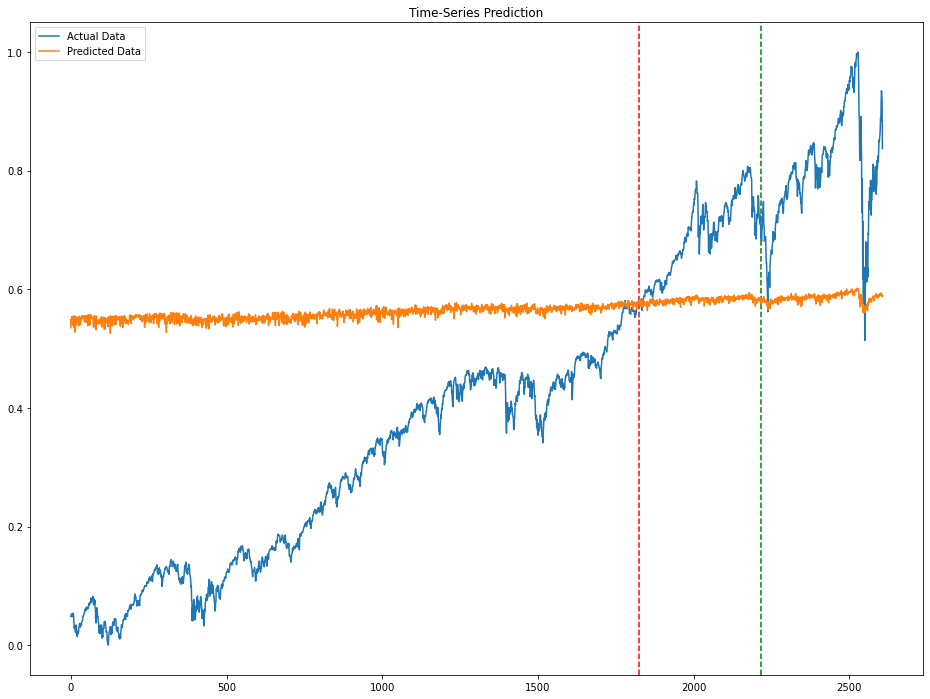

In [14]:
train_predict, _ = lstm_reg(torch.Tensor(X)) #forward pass
data_predict = train_predict.data.numpy() #numpy conversion
data_predict =  np.reshape(data_predict, (data_predict.shape[0],1))
dataY_plot = torch.Tensor(y).data.numpy()
dataY_plot =  np.reshape(dataY_plot, (dataY_plot.shape[0],1))

#data_predict = mm.inverse_transform(data_predict) #reverse transformation
#dataY_plot = mm.inverse_transform(dataY_plot)

plt.figure(figsize=(16,12)) #plotting
plt.axvline(x=split_tr, c='r', linestyle='--') #size of the training set
plt.axvline(x=split_val, c='g', linestyle='--') #size of the validation set

plt.plot(dataY_plot, label='Actual Data') #actual plot
plt.plot(data_predict, label='Predicted Data') #predicted plot
plt.title('Time-Series Prediction')
plt.legend()
plt.show()

In [17]:
train_predict, _ = lstm_reg(X_tensors) #forward pass
data_predict = train_predict.data.numpy() #numpy conversion
dataY_plot = y_tensors.data.numpy()
dataY_plot =  np.reshape(dataY_plot, (dataY_plot.shape[0],1))

#data_predict = mm.inverse_transform(data_predict) #reverse transformation
#dataY_plot = mm.inverse_transform(dataY_plot)

plt.figure(figsize=(18,16)) #plotting

plt.plot(dataY_plot[split_tr:split_val], label='Actual Data') #actual plot
plt.plot(data_predict[split_tr:split_val], label='Predicted Data') #predicted plot
plt.title('Validation dataset Prediction')
plt.legend()

# Show the major grid and style it slightly.
plt.grid(which='major', color='#AAA', linewidth=1.5)
# Show the minor grid as well. Style it in very light gray as a thin,
# dotted line.
plt.grid(which='minor', color='#BBB', linestyle=':', linewidth=1)
# Make the minor ticks and gridlines show.
plt.minorticks_on()

plt.show()

NameError: name 'X_tensors' is not defined

### Real forecasting by feeding the model's outputs as inputs

In [640]:
X_val_copy = X_val_tensors_final.clone()  # clone the tensors with a deep copy !
future_pred = [] # save lstm predictions
future_steps = 1

# initiate previous input values
x_pred = X_train_tensors_final[-future_steps : , :, :]
# last predictin of the lstm
out_pred, _ = lstm_reg(x_pred)
last_prediction = out_pred.flatten()
last_prediction

tensor([0.0798, 0.0956, 0.1012, 0.1005, 0.0826, 0.0900, 0.0896, 0.0873, 0.0875,
        0.0883, 0.0882, 0.0883, 0.0879, 0.0875, 0.0887, 0.0882, 0.0901, 0.0901,
        0.0911, 0.0931, 0.0913, 0.0915, 0.0911, 0.0916, 0.0920, 0.0884, 0.0879,
        0.0893, 0.0906, 0.0903], grad_fn=<ReshapeAliasBackward0>)

In [641]:
X_val_copy = X_val_tensors_final.clone()  # clone the tensors with a deep copy !
future_pred = [] # save lstm predictions
future_steps = 2

# initiate previous input values
x_pred = X_train_tensors_final[-future_steps : , :, :]
# last predictin of the lstm
out_pred, _ = lstm_reg(x_pred)
last_prediction = out_pred.flatten()
last_prediction

tensor([0.0724, 0.1049, 0.0982, 0.0984, 0.0973, 0.0851, 0.0886, 0.0895, 0.0877,
        0.0878, 0.0884, 0.0883, 0.0884, 0.0880, 0.0876, 0.0887, 0.0882, 0.0901,
        0.0901, 0.0911, 0.0931, 0.0913, 0.0915, 0.0911, 0.0916, 0.0920, 0.0884,
        0.0879, 0.0893, 0.0906, 0.0798, 0.0956, 0.1012, 0.1005, 0.0826, 0.0900,
        0.0896, 0.0873, 0.0875, 0.0883, 0.0882, 0.0883, 0.0879, 0.0875, 0.0887,
        0.0882, 0.0901, 0.0901, 0.0911, 0.0931, 0.0913, 0.0915, 0.0911, 0.0916,
        0.0920, 0.0884, 0.0879, 0.0893, 0.0906, 0.0903],
       grad_fn=<ReshapeAliasBackward0>)

In [618]:
lstm_reg(x_pred).flatten()

AttributeError: 'tuple' object has no attribute 'flatten'

In [516]:
X_val_copy = X_test_tensors_final.clone()  # clone the tensors with a deep copy !
future_pred = [] # save lstm predictions
future_steps = 50

# initiate previous input values
x_pred = X_train_tensors_final[-future_steps : , :, :]
# last predictin of the lstm
last_prediction = lstm_reg(x_pred).flatten()[-1]
for step in range(future_steps) :
    # predict next step
    last_prediction = lstm_reg(x_pred).flatten()[-1].item()
    # replace the real next day price with the lstm prediction but keep news sentiment intact. 
    X_val_copy[0, :, 0] = last_prediction
    
    # feed the last forecast back to the model as an input
    x_pred = torch.cat((x_pred, X_val_copy[0].view(-1, seq_len, 4) ), 0)
    
    # save the forecast
    future_pred.append(last_prediction)

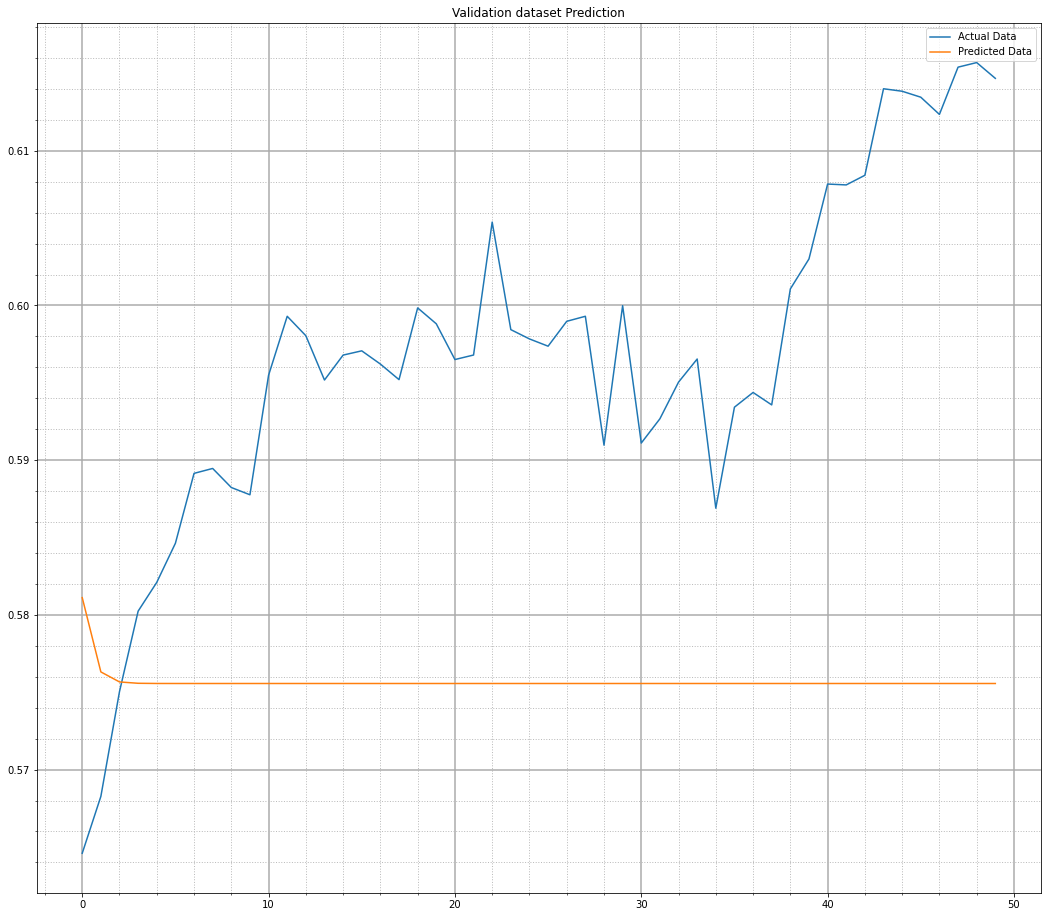

In [517]:
data_predict = future_pred
data_predict = np.array(data_predict).reshape((-1,1))
dataY_plot = y_tensors.data.numpy()
dataY_plot =  np.reshape(dataY_plot, (dataY_plot.shape[0],1))

#data_predict = mm.inverse_transform(data_predict) #reverse transformation
#dataY_plot = mm.inverse_transform(dataY_plot)

plt.figure(figsize=(18,16)) #plotting

prediction_len = data_predict.shape[0]
plt.plot(dataY_plot[split_tr : split_tr + prediction_len], label='Actual Data') #actual plot
plt.plot(data_predict, label='Predicted Data') #predicted plot
plt.title('Validation dataset Prediction')
plt.legend()

# Show the major grid and style it slightly.
plt.grid(which='major', color='#AAA', linewidth=1.5)
# Show the minor grid as well. Style it in very light gray as a thin,
# dotted line.
plt.grid(which='minor', color='#BBB', linestyle=':', linewidth=1)
# Make the minor ticks and gridlines show.
plt.minorticks_on()

plt.show()

### Evaluation of regression predictions with MSE and Spearman Correlation. 

In [428]:
#from sklearn.metric import mean_squared_error
mse = (np.power(dataY_plot[split_tr : split_val] - data_predict[split_tr : split_val], 2).mean())
print("VAL DATA, MSE loss : ", mse)

#from sklearn.metric import mean_squared_error
mse = (np.power(dataY_plot[:split_tr] - data_predict[:split_tr], 2).mean())
print("TRAIN DATA , MSE loss : ", mse)

ValueError: operands could not be broadcast together with shapes (387,1) (0,1) 

In [86]:
from scipy.stats import spearmanr, pearsonr
#from sklearn.metric import mean_squared_error
spearman1 = spearmanr(dataY_plot[split_tr : split_val], data_predict[split_tr : split_val])
print("Val DATA,  Spreaman correlation : ", spearman1)
pearson1, p1  = pearsonr(np.squeeze(dataY_plot[split_tr : split_val]), np.squeeze(data_predict[split_tr : split_val]))
print("Val DATA,  Pearson correlation=", pearson1, ", pvalue=",p1)
print()

#from sklearn.metric import mean_squared_error
spearman2 = spearmanr(dataY_plot[:split_tr],data_predict[:split_tr])
print("TRAIN DATA , Spreaman correlation : ", spearman2)
pearson2, p2= pearsonr(np.squeeze(dataY_plot[:split_tr]), np.squeeze(data_predict[:split_tr]))
print("TRAIN DATA,  Pearson correlation=", pearson2, ", pvalue=",p2)

Val DATA,  Spreaman correlation :  SpearmanrResult(correlation=0.9865399658063911, pvalue=4.919781950153785e-308)
Val DATA,  Pearson correlation= 0.9905439234782536 , pvalue= 0.0

TRAIN DATA , Spreaman correlation :  SpearmanrResult(correlation=0.9982257023326317, pvalue=0.0)
TRAIN DATA,  Pearson correlation= 0.9992579429664816 , pvalue= 0.0


#### Test dataset evaluation (Run only once at the end)

In [87]:
#from sklearn.metric import mean_squared_error
mse = (np.power(dataY_plot[split_val:] - data_predict[split_val:], 2).mean())
print("TEST DATA, MSE loss : ", mse)

spearman = spearmanr(dataY_plot[split_val:],data_predict[split_val:])
print("TEST DATA,  Spreaman correlation : ", spearman)

pearson3, p3= pearsonr(np.squeeze(dataY_plot[split_val:]), np.squeeze(data_predict[split_val:]))
print("TEST DATA,  Pearson correlation=", pearson3, ", pvalue=",p3)

TEST DATA, MSE loss :  6807.147
TEST DATA,  Spreaman correlation :  SpearmanrResult(correlation=0.9786468590101701, pvalue=2.187546843496833e-269)
TEST DATA,  Pearson correlation= 0.973608233471887 , pvalue= 1.0522306050801658e-251


# 2.) Classification of price movement with LSTM 

## Pre-process dataset


### Price_change is the class . 0: decrease , +1 : increase

Normalise the Close price column and convert Price_change column to (0,1) instead of (-1, 1). 

In [18]:
big_df['Price_change'] = big_df['Price_change'].apply(lambda x : x+1 if (x==-1) else x)
big_df['Close'] = (big_df['Close']-big_df['Close'].min())/(big_df['Close'].max()-big_df['Close'].min())
big_df

,Unnamed: 0,date,Volume,Close,Positive,Negative,Neutral,Price_change
0,0,2010-01-05,1.111477e+07,0.048207,0.157785,0.489590,0.352625,1
1,1,2010-01-06,9.592200e+06,0.048469,0.159253,0.114102,0.726645,1
2,2,2010-01-07,1.264640e+07,0.050394,0.441000,0.012006,0.546994,1
3,3,2010-01-08,1.508503e+07,0.051786,0.039152,0.384472,0.576376,1
4,4,2010-01-11,7.396000e+06,0.052632,0.114053,0.029774,0.856173,1
...,...,...,...,...,...,...,...,...
2603,2603,2020-06-05,2.503270e+07,0.918674,0.567891,0.070503,0.361606,1
2604,2604,2020-06-08,2.303770e+07,0.934946,0.523481,0.124646,0.351873,1
2605,2605,2020-06-09,2.969893e+07,0.924280,0.296441,0.337487,0.366072,0
2606,2606,2020-06-10,3.795272e+07,0.917070,0.390972,0.240399,0.368628,0


In [19]:
seq_len = 1
# start creating sequences only after the first seq_len elements have passed 
X = np.zeros((big_df.shape[0] - seq_len, 4))
y = np.zeros((big_df.shape[0] - seq_len, 2))
print("X shape :",X.shape)
print("y shape :",y.shape)

X shape : (2607, 4)
y shape : (2607, 2)


#### Sparse vector format labels.

In [20]:
for i in range(seq_len , X.shape[0] + seq_len) :
    prev_elems = big_df.iloc[i-seq_len][['Close', 'Positive', 'Negative', 'Neutral']] # previous available date
    # only the desired values
    prev_elems = [ prev_elems[p] for p in range(len(prev_elems))]
    prev_elems = np.array(prev_elems)
    # Store previous 30 days close price
    X[i-seq_len] = prev_elems
   # y[i-seq_len]  = big_df.iloc[i]['Price_change']
    # Store label, close price of day 31 
    change = big_df.iloc[i]['Price_change']
    if change==0 : # decrease
        y[i-seq_len] = np.array([0, 1]) # vector for decrease
    else : 
        y[i-seq_len] = np.array([1, 0]) # vector for increase

#### Binary format labels

In [21]:
'''
for i in range(seq_len , X.shape[0] + seq_len) :
    prev_elems = big_df.iloc[i-seq_len][['Close', 'Positive', 'Negative', 'Neutral']] # previous available date
    # only the desired values
    prev_elems = [ prev_elems[p] for p in range(len(prev_elems))]
    prev_elems = np.array(prev_elems)
    # Store previous 30 days close price
    X[i-seq_len] = prev_elems
    y[i-seq_len]  = big_df.iloc[i]['Price_change']
'''

"\nfor i in range(seq_len , X.shape[0] + seq_len) :\n    prev_elems = big_df.iloc[i-seq_len][['Close', 'Positive', 'Negative', 'Neutral']] # previous available date\n    # only the desired values\n    prev_elems = [ prev_elems[p] for p in range(len(prev_elems))]\n    prev_elems = np.array(prev_elems)\n    # Store previous 30 days close price\n    X[i-seq_len] = prev_elems\n    y[i-seq_len]  = big_df.iloc[i]['Price_change']\n"

### Normalise dataset and split into train-test.
#### Convert np.arrays into tensors and reshape in the format expected by the LSTM .
Min - Max scaling 

In [24]:
# transform features with standard scaler, and output values (close prices) to [0,1] with minmax scaler
from torch.autograd import Variable
from sklearn.preprocessing import StandardScaler, MinMaxScaler
mm = MinMaxScaler()
#ss = StandardScaler()
#X_price_norm = mm.fit_transform(X[:,0])
X_mm = X # mm.fit_transform(X)

# fraction of the test set.
percentage = 0.4
split_tr = ceil(X_mm.shape[0] *(1-percentage))
split_val = ceil(X_mm.shape[0] *(1- percentage/2))

X_train = X_mm[0:split_tr]
y_train = y[0:split_tr]
X_val= X_mm[split_tr: split_val]
y_val= y[split_tr: split_val]
X_test= X_mm[split_val:]
y_test= y[split_val:]
print(f"Train data shapes X:{X_train.shape} , y:{y_train.shape}")
print(f"Test data shapes X:{X_test.shape} , y:{y_test.shape}")
print(f"Val data shapes X:{X_val.shape} , y:{y_val.shape}")

### TO tensors 
###
X_tensors = Variable(torch.Tensor(X_mm))
y_tensors = Variable(torch.Tensor(y))
#reshaping to rows, timestamps, features
X_tensors = torch.reshape(X_tensors,   (X_tensors.shape[0], 1, X_tensors.shape[1]))
y_tensors = torch.reshape(y_tensors,  (y_tensors.shape[0], 1, y_tensors.shape[1]))

X_train_tensors = Variable(torch.Tensor(X_train))
X_test_tensors = Variable(torch.Tensor(X_test))
X_val_tensors = Variable(torch.Tensor(X_val))
y_train_tensors = Variable(torch.Tensor(y_train))
y_test_tensors = Variable(torch.Tensor(y_test))
y_val_tensors = Variable(torch.Tensor(y_val))

#reshaping to rows, timestamps, features
X_train_tensors_final = torch.reshape(X_train_tensors,   (X_train_tensors.shape[0], 1, X_train_tensors.shape[1]))
X_test_tensors_final = torch.reshape(X_test_tensors,  (X_test_tensors.shape[0], 1, X_test_tensors.shape[1]))
X_val_tensors_final = torch.reshape(X_val_tensors,  (X_val_tensors.shape[0], 1, X_val_tensors.shape[1]))

print("Training Shape", X_train_tensors_final.shape, y_train_tensors.shape)
print("Testing Shape", X_test_tensors_final.shape, y_test_tensors.shape)
print("Validation Shape", X_val_tensors_final.shape, y_val_tensors.shape)

Train data shapes X:(1565, 4) , y:(1565, 2)
Test data shapes X:(521, 4) , y:(521, 2)
Val data shapes X:(521, 4) , y:(521, 2)
Training Shape torch.Size([1565, 1, 4]) torch.Size([1565, 2])
Testing Shape torch.Size([521, 1, 4]) torch.Size([521, 2])
Validation Shape torch.Size([521, 1, 4]) torch.Size([521, 2])


### Define classification LSTM  : We need to add a sigmoid activation function at the end in order to get output in the $[0,1]$ range.

In [25]:
class LSTM_clf(nn.Module):
    def __init__(self, num_classes, input_size, hidden_size, num_layers, dropout=0.3, fc_size = 128):
        super(LSTM_clf, self).__init__()
        self.num_classes = num_classes #number of classes
        self.num_layers = num_layers #number of layers
        self.input_size = input_size #input size
        self.hidden_size = hidden_size #hidden state

        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size,
                            num_layers=num_layers, batch_first=True, dropout=dropout) #lstm
        
        self.fc_1 =  nn.Linear(hidden_size * num_layers, fc_size) #fully connected 1
        self.fc = nn.Linear(fc_size, num_classes) #fully connected last layer
        self.dropout = nn.Dropout(p=dropout)

        self.relu = nn.ReLU()
        # sigmoid activation for end classification
        self.sigm = nn.Sigmoid()
        self.tanh = nn.Tanh()

    def forward(self,x):
        h_0_0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size)) #hidden state 1st lstm layer
        c_0_0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size)) #internal state 1st lstm layer

        # Propagate input through LSTM
        output, (hn, cn) = self.lstm(x, (h_0_0, c_0_0)) #lstm with input, hidden, and internal state
       # print(output.shape)
       # print(hn.shape)
        hn = hn.view(-1, self.hidden_size * num_layers) #reshaping (flatten) the data for Dense layer next
       # print(hn.shape)
        out = self.relu(hn)
        out = self.fc_1(out) #first Dense
        out = self.dropout(out)
        out = self.relu(out) #relu
        out = self.fc(out) #Final Output
        
        out = self.sigm(out)
        return out

#### Training the LSTM . 

In [40]:
#hyperparameters
num_epochs = 1000 #1000 epochs
learning_rate = 0.0001
input_size = 4 #number of features
hidden_size = 60 #number of features in hidden state
num_layers = 1 #number of stacked lstm layers

num_classes = 2 #number of output classes

lstm_clf = LSTM_clf(num_classes, input_size, hidden_size, num_layers, dropout = 0.3, fc_size=128)#X_train_tensors_final.shape[1]) #our lstm class

criterion = torch.nn.BCELoss() #   # mean-squared error for regression
optimizer = torch.optim.Adam(lstm_clf.parameters(), lr=learning_rate)


plot_loss_tr = []
plot_loss_val = []
for epoch in tqdm(range(num_epochs)):
    
    #print(X_train_tensors_final.shape)
    outputs = lstm_clf.forward(X_train_tensors_final) #forward pass
    optimizer.zero_grad() #caluclate the gradient, manually setting to 0
    #print(outputs.shape)
    #print(y_train_tensors.shape)
    # obtain the loss function
    loss = criterion(outputs, y_train_tensors)
    plot_loss_tr.append(loss.item())
    loss.backward() #calculates the loss of the loss function

    # Compute validation loss
    val_outs = lstm_clf.forward(X_val_tensors_final) #forward pass
    val_loss = criterion(val_outs, y_val_tensors)
    plot_loss_val.append(val_loss.item())
    
    optimizer.step() #improve from loss, i.e backprop
    if epoch % 100 == 0:
        print("Epoch: %d, train_loss: %1.5f,  val_loss: %1.5f " % (epoch, loss.item(), val_loss.item()))

C:\Users\Konpoul\miniconda3\envs\torch\lib\site-packages\torch\nn\modules\rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
  1%|▋                                                                                | 9/1000 [00:00<00:22, 44.35it/s]

Epoch: 0, train_loss: 0.69328,  val_loss: 0.69333 


 10%|████████▎                                                                      | 105/1000 [00:02<00:17, 51.55it/s]

Epoch: 100, train_loss: 0.69092,  val_loss: 0.68972 


 21%|████████████████▍                                                              | 208/1000 [00:04<00:14, 54.44it/s]

Epoch: 200, train_loss: 0.68953,  val_loss: 0.68893 


 30%|████████████████████████                                                       | 305/1000 [00:06<00:13, 50.05it/s]

Epoch: 300, train_loss: 0.68883,  val_loss: 0.68765 


 41%|████████████████████████████████▋                                              | 413/1000 [00:08<00:10, 54.97it/s]

Epoch: 400, train_loss: 0.68885,  val_loss: 0.68857 


 51%|████████████████████████████████████████▏                                      | 509/1000 [00:10<00:08, 55.39it/s]

Epoch: 500, train_loss: 0.68829,  val_loss: 0.68740 


 60%|███████████████████████████████████████████████▊                               | 605/1000 [00:11<00:07, 53.57it/s]

Epoch: 600, train_loss: 0.68813,  val_loss: 0.68795 


 71%|███████████████████████████████████████████████████████▊                       | 707/1000 [00:13<00:05, 54.56it/s]

Epoch: 700, train_loss: 0.68701,  val_loss: 0.68901 


 81%|███████████████████████████████████████████████████████████████▉               | 810/1000 [00:15<00:03, 57.00it/s]

Epoch: 800, train_loss: 0.68598,  val_loss: 0.68777 


 90%|███████████████████████████████████████████████████████████████████████▎       | 902/1000 [00:17<00:02, 44.12it/s]

Epoch: 900, train_loss: 0.68666,  val_loss: 0.69063 


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:19<00:00, 51.52it/s]


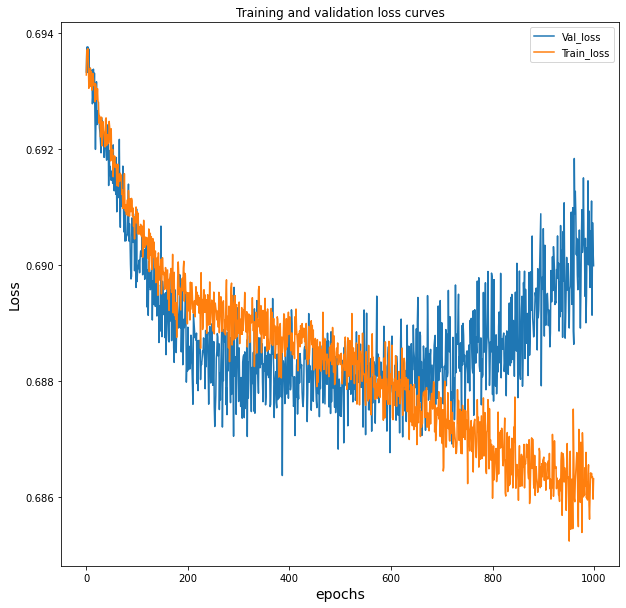

In [41]:
fig , ax = plt.subplots(figsize = (10,10))

plt.plot(plot_loss_val, label='Val_loss') #actual plot
plt.plot(plot_loss_tr, label='Train_loss') #predicted plot
plt.title('Training and validation loss curves')
plt.xlabel('epochs', fontsize=14)
plt.ylabel('Loss', fontsize=14)
plt.legend()
plt.show()

### Prediction and evaluation of LSTM classifier .

 predictions in the right form to be accepted by sklearn accuracy functions and confusion matrix

In [42]:
train_predict = lstm_clf(X_tensors) #forward pass
data_predict = train_predict.data.numpy() #numpy conversion
for i in range(len(data_predict)):
    index = np.argmax(data_predict, axis=1) # np.where(data_predict >=0.5, 1, 0) #
    if (index[i] == 0) :
        data_predict[i][index] = 1
        data_predict[i][1] = 0 
    else :
        data_predict[i][0] = 0
        data_predict[i][1] = 1 

In [43]:
from sklearn.metrics import accuracy_score, balanced_accuracy_score

#from sklearn.metric import mean_squared_error
acc = accuracy_score(y[:split_tr], data_predict[:split_tr])
print("TRAIN DATA , accuracy : ", round(acc,6))

#bacc =  balanced_accuracy_score(y[:split_tr], predictions[:split_tr])
#print("TRAIN DATA , balanced accuracy : ", round(bacc,6))

acc = accuracy_score(y[split_tr : split_val], data_predict[split_tr : split_val])
print("VAL DATA, accuracy : ", round(acc,6))

TRAIN DATA , accuracy :  0.553994
VAL DATA, accuracy :  0.545106


In [44]:
# Number of increase predictions 
print("Number of increase label predictions :",data_predict[data_predict[:,0] == 1].shape)
print("Number of decrease label predictions :",data_predict[data_predict[:,1] == 1].shape)
print("Overall data dataset shape : ",data_predict.shape)

Number of increase label predictions : (1881, 2)
Number of decrease label predictions : (726, 2)
Overall data dataset shape :  (2607, 2)


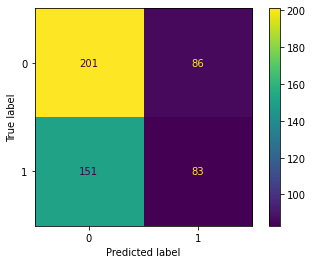

In [45]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

y_conf = np.argmax(y, axis=1)
pred_conf = np.argmax(data_predict, axis=1)

cm = confusion_matrix(y_conf[split_tr : split_val] , pred_conf[split_tr : split_val], labels=[0,1])
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=[0,1])
disp.plot()
plt.show()

#### TEST EVALUATION

TEST DATA, accuracy :  0.479846


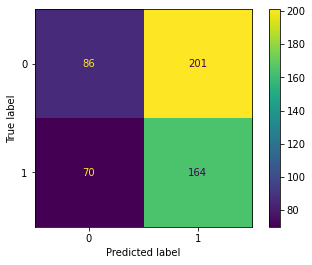

In [39]:
acc = accuracy_score(y_conf[split_val:], pred_conf[split_val:])
print("TEST DATA, accuracy : ", round(acc,6))

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_conf[split_val:] , pred_conf[split_val:], labels=[0,1])
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                         display_labels=[0,1])
disp.plot()
plt.show()